In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score

In [2]:
def LoadForecasting_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

In [3]:
df=pd.read_csv('dataset/TrainingSet.csv')

In [4]:
df

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,...,1,1,2,0,0,0,1,2,0,Normal
1,2,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,...,1,1,2,0,0,0,1,2,0,Normal
2,3,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,...,1,1,3,0,0,0,1,3,0,Normal
3,4,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,...,2,1,3,0,0,0,2,3,0,Normal
4,5,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,...,2,1,3,0,0,0,2,3,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,...,1,1,2,0,0,0,2,1,0,Normal
82328,82329,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,...,1,1,1,0,0,0,3,2,0,Normal
82329,82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,...,1,1,1,0,0,0,1,1,1,Normal
82330,82331,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,...,1,1,1,0,0,0,1,1,1,Normal


In [5]:
df.columns

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat'],
      dtype='object')

In [8]:
df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   spkts              82332 non-null  int64  
 3   dpkts              82332 non-null  int64  
 4   sbytes             82332 non-null  int64  
 5   dbytes             82332 non-null  int64  
 6   rate               82332 non-null  float64
 7   sttl               82332 non-null  int64  
 8   dttl               82332 non-null  int64  
 9   sload              82332 non-null  float64
 10  dload              82332 non-null  float64
 11  sloss              82332 non-null  int64  
 12  dloss              82332 non-null  int64  
 13  sinpkt             82332 non-null  float64
 14  dinpkt             82332 non-null  float64
 15  sjit               82332 non-null  float64
 16  djit               823

In [10]:
df.isnull().sum()

id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
dtype: int64

In [11]:
df['attack_cat'].unique()

array(['Normal', 'Scaling Attack', 'Ramping Attack', 'Random Attack',
       'Smooth Curve Attack', 'Pulse Attack'], dtype=object)

In [12]:
df['attack_cat'].value_counts()


Normal                 37000
Pulse Attack           24933
Smooth Curve Attack    11176
Scaling Attack          4173
Random Attack           4089
Ramping Attack           961
Name: attack_cat, dtype: int64

In [13]:
df1=df[(df['attack_cat']=='Normal') | (df['attack_cat']=='Scaling Attack')]

In [14]:
df1

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,...,1,1,2,0,0,0,1,2,0,Normal
1,2,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,...,1,1,2,0,0,0,1,2,0,Normal
2,3,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,...,1,1,3,0,0,0,1,3,0,Normal
3,4,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,...,2,1,3,0,0,0,2,3,0,Normal
4,5,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,...,2,1,3,0,0,0,2,3,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,...,1,1,2,0,0,0,2,1,0,Normal
82328,82329,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,...,1,1,1,0,0,0,3,2,0,Normal
82329,82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,...,1,1,1,0,0,0,1,1,1,Normal
82330,82331,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,...,1,1,1,0,0,0,1,1,1,Normal


In [15]:
df1['attack_cat'].unique()

array(['Normal', 'Scaling Attack'], dtype=object)

In [16]:
df2=df[(df['attack_cat']=='Smooth Curve Attack') | (df['attack_cat']=='Pulse Attack')]

In [17]:
df2

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
247,248,0.000009,2,0,104,0,111111.107200,254,0,4.622222e+07,...,1,1,2,0,0,0,1,1,0,Smooth Curve Attack
249,250,0.000009,2,0,156,0,111111.107200,254,0,6.933333e+07,...,1,1,63,0,0,0,1,1,0,Smooth Curve Attack
250,251,0.000009,2,0,156,0,111111.107200,254,0,6.933333e+07,...,1,1,63,0,0,0,1,1,0,Smooth Curve Attack
251,252,0.000009,2,0,156,0,111111.107200,254,0,6.933333e+07,...,1,1,63,0,0,0,1,1,0,Smooth Curve Attack
252,253,0.000016,2,0,196,0,62500.000160,254,0,4.900000e+07,...,1,1,1,0,0,0,1,1,0,Smooth Curve Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65847,65848,0.000012,2,0,1510,0,83333.330390,254,0,5.033333e+08,...,1,1,1,0,0,0,1,5,0,Pulse Attack
65848,65849,20.542910,4,0,1216,0,0.146036,254,0,3.551590e+02,...,1,1,1,0,0,0,1,6,0,Pulse Attack
65849,65850,20.542910,4,0,1216,0,0.146036,254,0,3.551590e+02,...,1,1,1,0,0,0,1,6,0,Pulse Attack
65850,65851,0.627022,10,6,590,268,23.922605,254,252,6.774882e+03,...,1,1,1,0,0,0,1,5,0,Pulse Attack


In [18]:
df2['attack_cat'].unique()

array(['Smooth Curve Attack', 'Pulse Attack'], dtype=object)

In [19]:
final_data=df1.merge(df2,how='outer')  #data=df1.join(df_1,how='outer')

In [20]:
final_data

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,...,1,1,2,0,0,0,1,2,0,Normal
1,2,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,...,1,1,2,0,0,0,1,2,0,Normal
2,3,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,...,1,1,3,0,0,0,1,3,0,Normal
3,4,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,...,2,1,3,0,0,0,2,3,0,Normal
4,5,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,...,2,1,3,0,0,0,2,3,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77277,65848,0.000012,2,0,1510,0,83333.330390,254,0,5.033333e+08,...,1,1,1,0,0,0,1,5,0,Pulse Attack
77278,65849,20.542910,4,0,1216,0,0.146036,254,0,3.551590e+02,...,1,1,1,0,0,0,1,6,0,Pulse Attack
77279,65850,20.542910,4,0,1216,0,0.146036,254,0,3.551590e+02,...,1,1,1,0,0,0,1,6,0,Pulse Attack
77280,65851,0.627022,10,6,590,268,23.922605,254,252,6.774882e+03,...,1,1,1,0,0,0,1,5,0,Pulse Attack


In [21]:
final_data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,77282.000000,77282.000000,77282.000000,77282.000000,7.728200e+04,7.728200e+04,7.728200e+04,77282.000000,77282.000000,7.728200e+04,...,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000,77282.000000
mean,42276.444877,0.954310,18.294713,17.138493,7.364982e+03,1.250515e+04,7.929614e+04,177.779250,97.648987,6.117154e+07,...,5.951360,5.097319,3.750149,7.694263,0.008747,0.008851,0.132334,6.564802,9.424510,0.011853
std,23350.128361,4.361600,122.399382,76.429601,1.573963e+05,9.792388e+04,1.475500e+05,102.656296,116.825979,1.776072e+08,...,8.631609,8.617349,6.074149,11.707170,0.093671,0.095033,0.654547,8.722135,11.375779,0.108224
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,22447.250000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.806772e+01,62.000000,0.000000,1.083718e+04,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
50%,41767.500000,0.018457,6.000000,4.000000,5.640000e+02,2.680000e+02,2.264745e+03,254.000000,29.000000,5.542388e+05,...,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000
75%,62832.750000,0.734756,12.000000,10.000000,1.390000e+03,1.084000e+03,1.111111e+05,254.000000,252.000000,5.700000e+07,...,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000
max,82332.000000,59.999989,10646.000000,3692.000000,1.435577e+07,4.930829e+06,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000


In [22]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77282 entries, 0 to 77281
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 77282 non-null  int64  
 1   dur                77282 non-null  float64
 2   spkts              77282 non-null  int64  
 3   dpkts              77282 non-null  int64  
 4   sbytes             77282 non-null  int64  
 5   dbytes             77282 non-null  int64  
 6   rate               77282 non-null  float64
 7   sttl               77282 non-null  int64  
 8   dttl               77282 non-null  int64  
 9   sload              77282 non-null  float64
 10  dload              77282 non-null  float64
 11  sloss              77282 non-null  int64  
 12  dloss              77282 non-null  int64  
 13  sinpkt             77282 non-null  float64
 14  dinpkt             77282 non-null  float64
 15  sjit               77282 non-null  float64
 16  djit               772

In [23]:
final_data['attack_cat'].unique()
final_data['attack_cat'].value_counts()

Normal                 37000
Pulse Attack           24933
Smooth Curve Attack    11176
Scaling Attack          4173
Name: attack_cat, dtype: int64

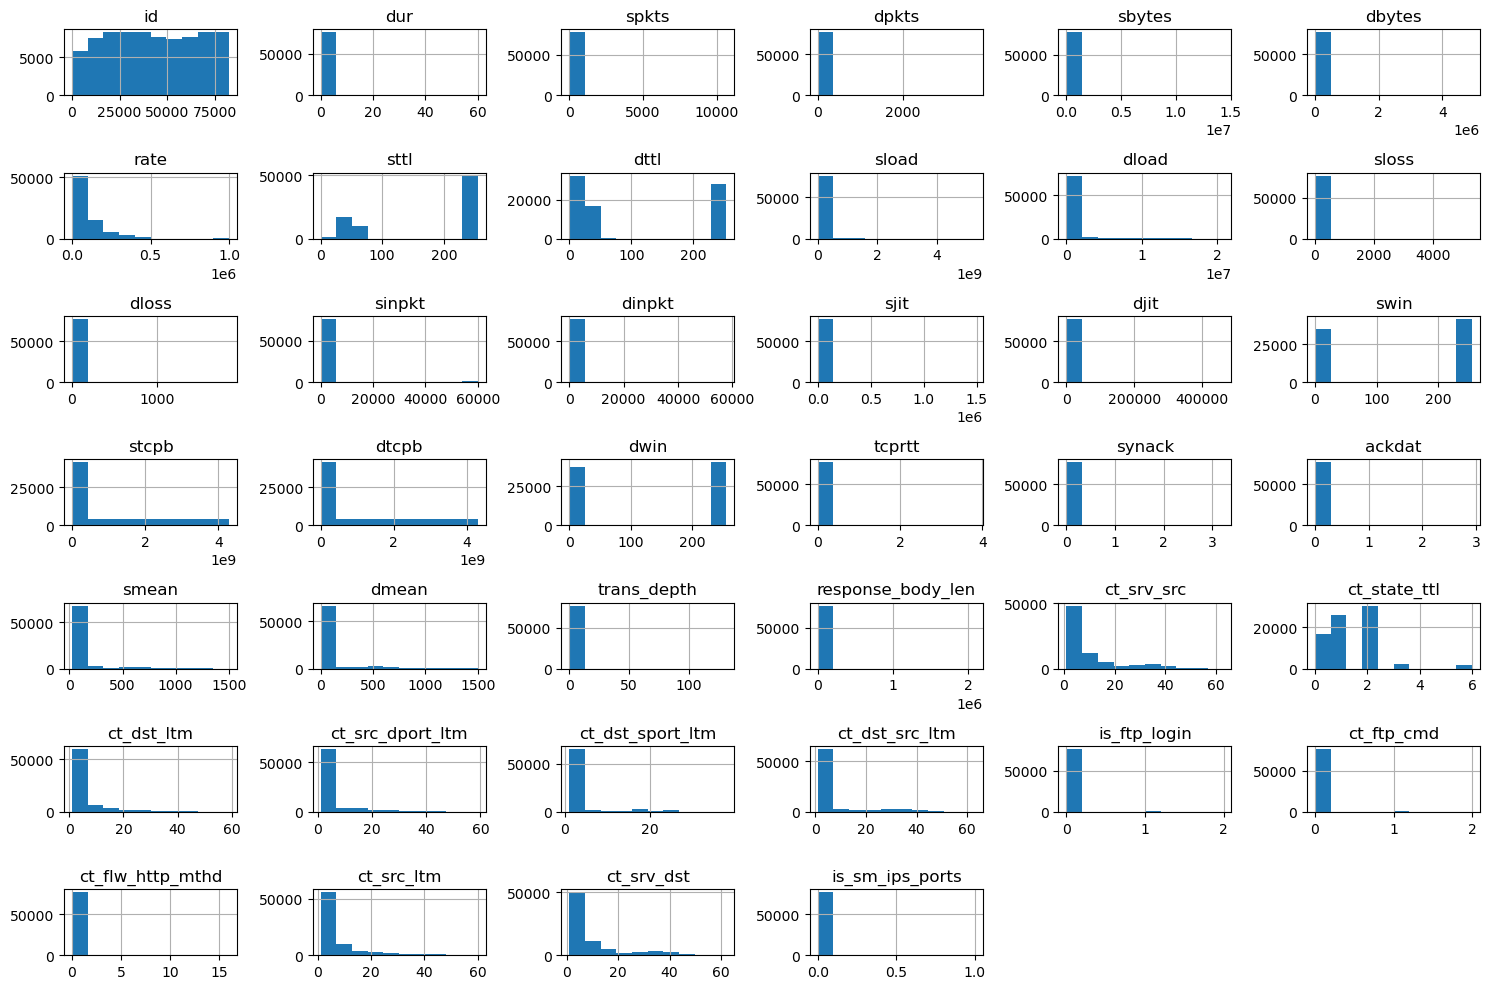

In [24]:
final_data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

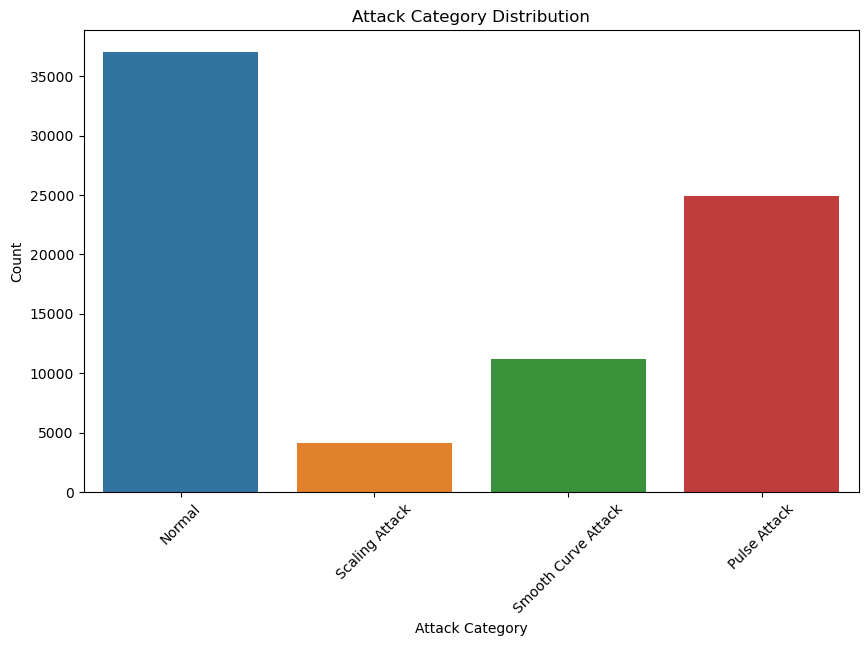

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(final_data['attack_cat'])
plt.title('Attack Category Distribution')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


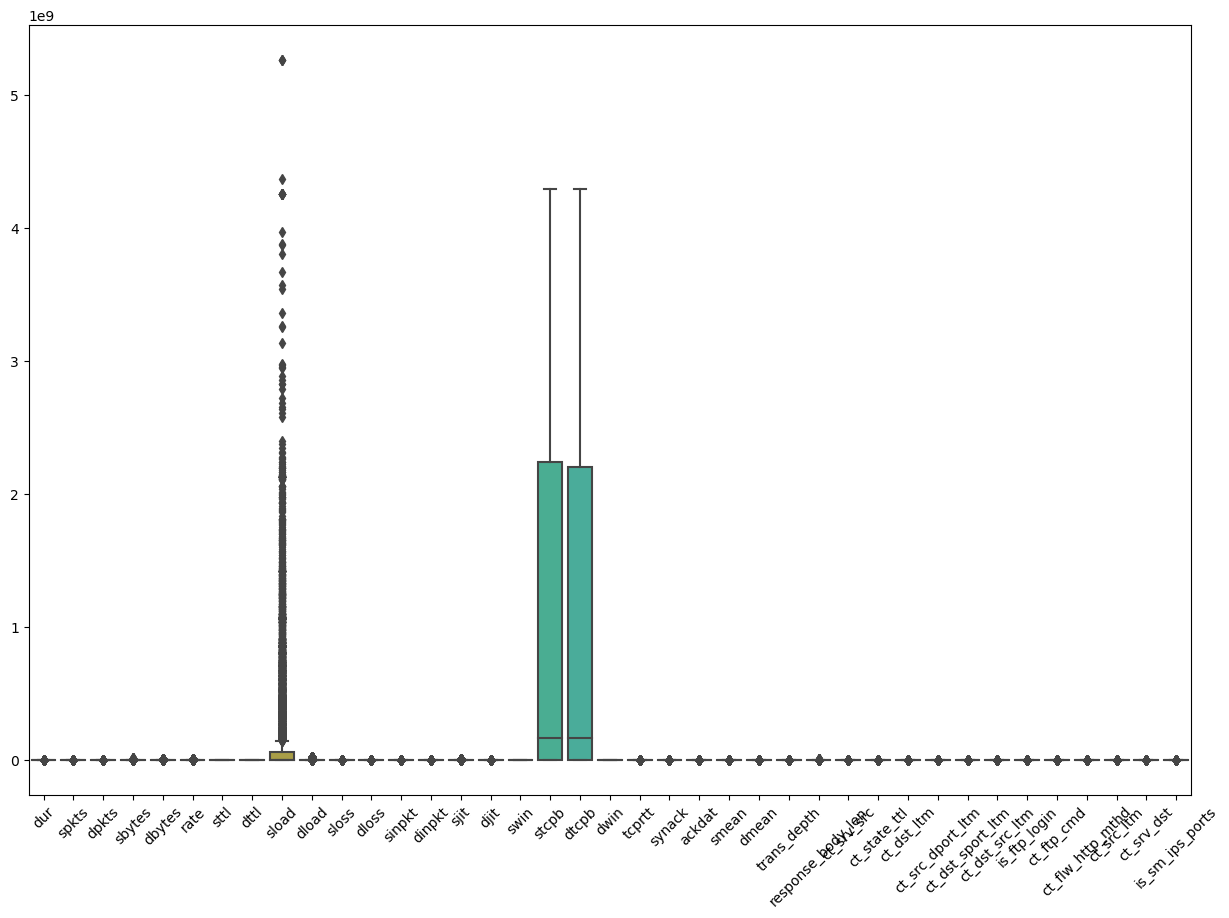

In [28]:
# Box plots for numerical variables
plt.figure(figsize=(15, 10))
sns.boxplot(data=final_data.drop(columns=['id', 'attack_cat']))
plt.xticks(rotation=45)
plt.show()


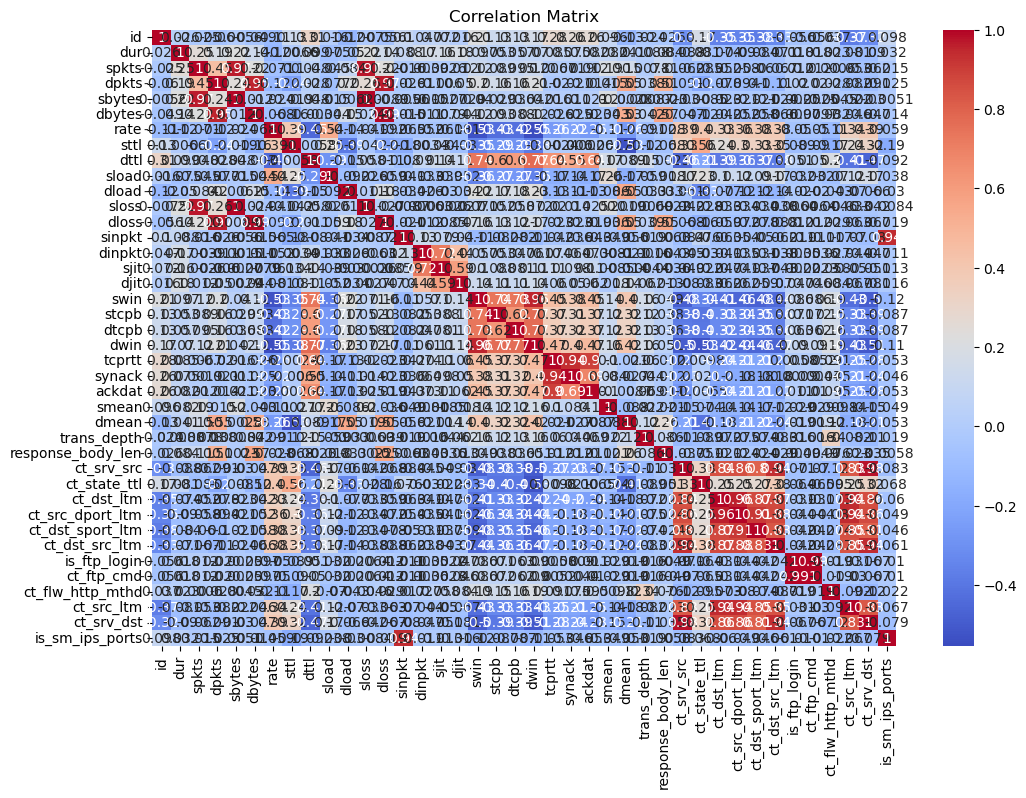

In [29]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(final_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

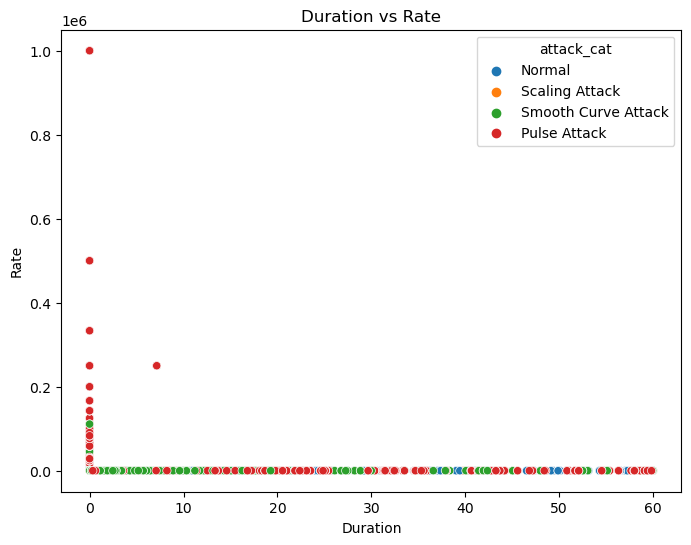

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(final_data['dur'], final_data['rate'], hue=final_data['attack_cat'])
plt.title('Duration vs Rate')
plt.xlabel('Duration')
plt.ylabel('Rate')
plt.show()


In [32]:
final_data.to_csv('data.csv')